<a href="https://colab.research.google.com/github/TheRamenGuy/Semantic_Segmentation_Using_U-Net/blob/main/Resizing_Image_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#We will be implementing the semantic segmentation of the dataset calculation by following the given steps -

## 1.  Resizing the images to a smaller dimension
## 2.  Creating the model by implementing a pre-trained resnet model (Resnet50) to set up inital weights for the U-Net model
## 3.  Predictions and visualization of the generated masks

## **1. Installing and importing necessary libraries**


In [ ]:
pip install patchify

In [ ]:
pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.5 MB/s eta 0:00:00


In [ ]:
import os as os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

Segmentation Models: using `tf.keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## **2. Data loading and manipulation**

In [ ]:
import re

def data_loader(folder_dir):
    image_dataset = []

    def sort_numerical(file_name):               # Sort file names numerically, this step is done to ensure no random selection can arise when os.listdir() fetches desired files in an unogranized order
        parts = re.findall(r'(\d+)', file_name)  # Not strictly necessary, but helps in preventing cases where mask and images are fetched on a random basis, which we do not want
        return tuple(int(part) for part in parts)

    for images in sorted(os.listdir(folder_dir), key=sort_numerical):
        image = cv2.imread(folder_dir + '/' + images, 1) #Navigating to the required directory
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #From BGR to RGB
        image = cv2.resize(image, (128, 128)) #Resizing images
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)

    return image_dataset

In [ ]:
image_dataset = data_loader('/content/drive/MyDrive/semantic_drone_dataset/training_set/images')

In [ ]:
image_dataset = np.array(image_dataset)
image_dataset.shape

(400, 128, 128, 3)

In [ ]:
mask_dataset = data_loader("/content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/label_images")

In [ ]:
mask_dataset = np.array(mask_dataset)
mask_dataset.shape

(400, 128, 128, 3)

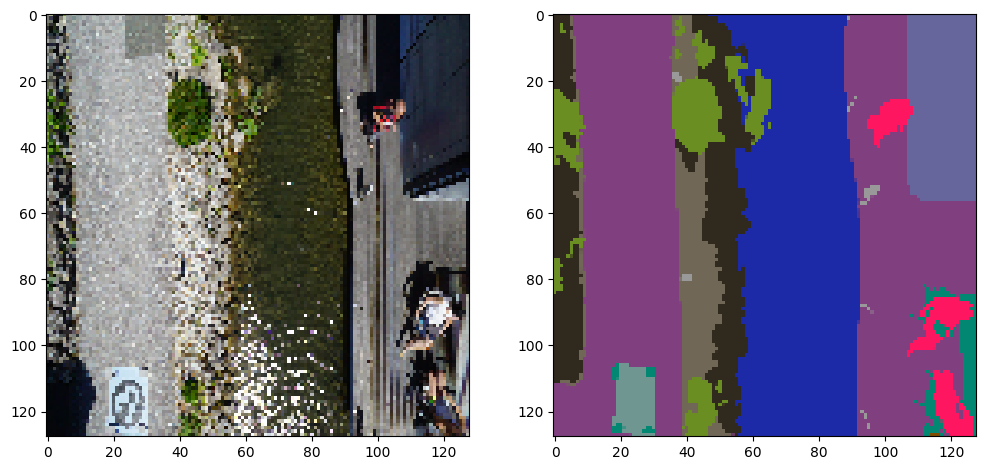

In [ ]:
image_number = random.randint(0, len(image_dataset))

#visualization and first check of respective images and their masks
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [ ]:
mask_labels = pd.read_csv('/content/drive/MyDrive/semantic_drone_dataset/training_set/gt/semantic/class_dict.csv')

In [ ]:
mask_labels #types of labels with their respective RGB color codes on mask

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [ ]:
# converting 3 values (RGB) to 1 label value
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]
    return label_seg

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels)
    labels.append(label)

In [ ]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


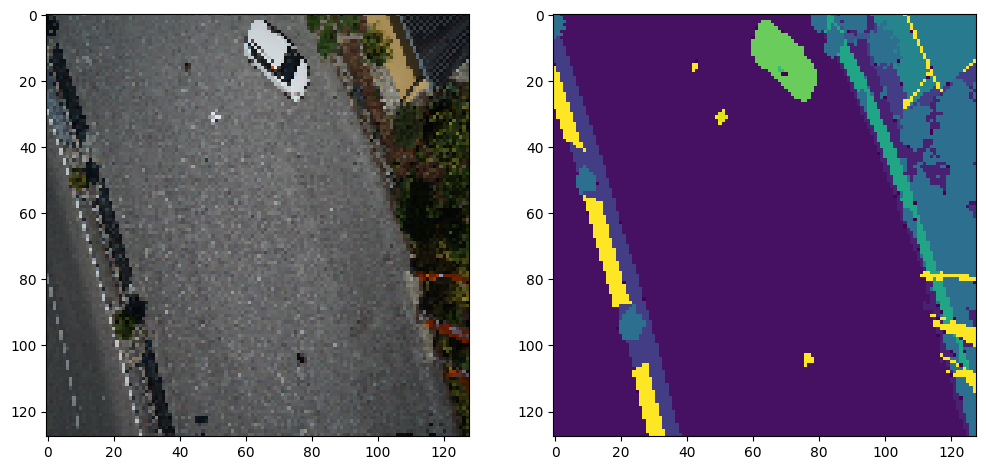

In [ ]:
print("Unique labels in label dataset are: ", np.unique(labels))

#second check if the masks are aligned with the respective images, important as an unordered set of image and mask can massively ruin the performance down the line.
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [ ]:
n_classes = len(np.unique(labels)) # 23 classes
labels_cat = to_categorical(labels, num_classes=n_classes)

In [ ]:
# train test split for the entire data, with 80% training and 20% train split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

##**3.Modelling**##

In [ ]:
#fetching weights pf the resnet50 model
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
#preprocessing
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [ ]:
#U-Net model implementation
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

94592056/94592056 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
#Accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem and not a binary one
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [ ]:
model_resnet_backbone.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)         │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_data                   │ (None, None, None, 3)  │              9 │ data[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, None, None, 3)  │              0 │ bn_data[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv0 (Conv2D)            │ (None, None, None, 64) │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn0 (BatchNormalization)  │ (None, None, None, 64) │            256 │ conv0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu0 (Activation)        │ (None, None, None, 64) │              0 │ bn0[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, None, None, 64) │              0 │ relu0[0][0]            │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooling0 (MaxPooling2D)   │ (None, None, None, 64) │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn1          │ (None, None, None, 64) │            256 │ pooling0[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu1        │ (None, None, None, 64) │              0 │ stage1_unit1_bn1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv1        │ (None, None, None, 64) │          4,096 │ stage1_unit1_relu1[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn2          │ (None, None, None, 64) │            256 │ stage1_unit1_conv1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu2        │ (None, None, None, 64) │              0 │ stage1_unit1_bn2[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, None, None, 64) │              0 │ stage1_unit1_relu2[0]… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv2        │ (None, None, None, 64) │         36,864 │ zero_padding2d_2[0][0] │
│ (Conv2D)             

 Total params: 32,564,304 (124.22 MB)

 Trainable params: 32,516,746 (124.04 MB)

 Non-trainable params: 47,558 (185.77 KB)

In [ ]:
history_1 = model_resnet_backbone.fit(X_train_prepr,
          y_train,
          batch_size=16,
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 305ms/step - accuracy: 0.2300 - loss: 2.8231 - val_accuracy: 0.2143 - val_loss: 92174.4062
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5754 - loss: 1.6720 - val_accuracy: 0.2122 - val_loss: 176.7581
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6169 - loss: 1.4405 - val_accuracy: 0.1389 - val_loss: 3493.0422
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6469 - loss: 1.2859 - val_accuracy: 0.2581 - val_loss: 3025.8247
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6680 - loss: 1.1921 - val_accuracy: 0.0956 - val_loss: 4939.5605
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6709 - loss: 1.1571 - val_accuracy: 0.3502 - val_loss: 7.5800
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6666 - loss: 1.1545 - val_accuracy: 0.4171 - val_loss: 4.1993
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6882 - loss: 1.0842 -

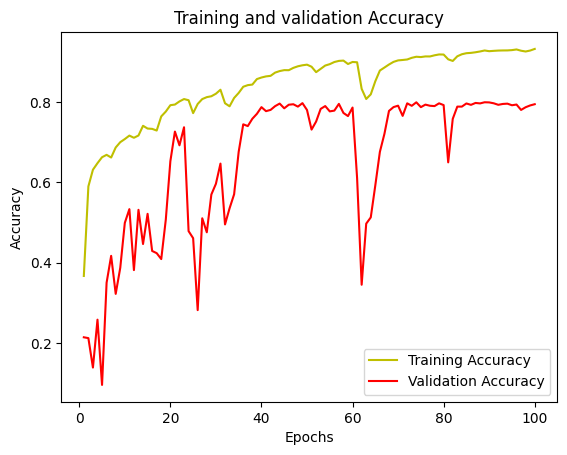

In [ ]:
history = history_1
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Saving the model for further use
model_resnet_backbone.save('../models/resnet_backbone.hdf5')

In [ ]:
model = load_model('../models/resnet_backbone.hdf5')

##**4.Predictions and Visualization**##

In [ ]:
#Finally, making predictions
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


In [ ]:
#Prediction on a random image taken from test data
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


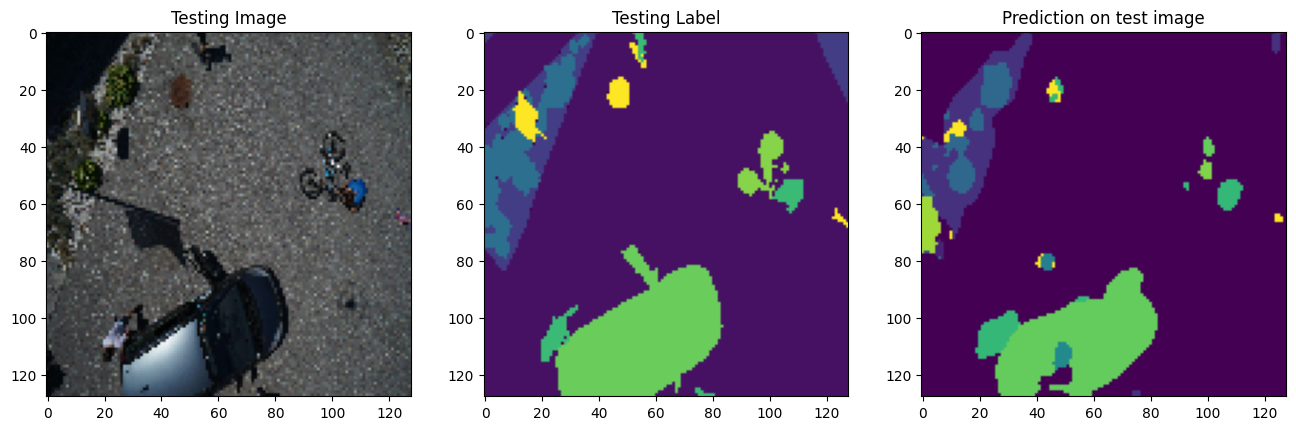

In [ ]:
#Visualizing the results
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image') #test image
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label') #actual mask
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image') #predicted mask
plt.imshow(predicted_img)
plt.show()
